# The main question about the problem is that
* which are fixture used to produce services or products in a factory or any business, into any failure state, how big a cost can they cause to a business or factory.
* or from other point of view, if we knew ahead of time when the production tools used in an organization might fail, how big of a production cost could we avoid for our organization?
  
  *in this notebook we focused on a machine learning model, which classifies an error that a machine make into an error types and maeks a prediction about the failure of the machine*

During the realization of the study i used multiple machine learning models in a single class, in this problem i mearsured the predictive power of the different machine learning i used by only looking at accuracy score values. (Recall, RMSE, MSE,AUC score etc)

In [2]:
! pip install --upgrade mplfinance

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
import datetime , pytz # pytz is an extension to datetime that provides comprehensive support for working with time zones and it convert time from one zone to another
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import pyplot
import yfinance as yf# library in Python is used for retrieving financial data, particularly historical stock price and trading volume information,
import investpy # allows you to retrieve a wide range of financial data, including historical and real-time data, related to stocks, indices, bonds, currencies, commodities, and economic indicators.
from stockstats import StockDataFrame
import matplotlib.dates as mpl_dates
from mpl_finance import candlestick_ohlc #create candlestick charts for visualizing price movements and patterns in financial data.
from scipy.stats import skew,norm
from scipy.signal import argrelextrema #  It helps identify the positions within the array where the data values reach local maxima or minima. Here's the primary use of this function:
import copy
from sklearn.cluster import KMeans
import time 
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows',2000)
pd.set_option('display.max_columns',50)

In [4]:
# let's import the dataset
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [5]:
df.shape

(10000, 10)

the dataset contain 10,000 and 10 column diferent columns

In [21]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [10]:
df['Target'].unique()

array([0, 1], dtype=int64)

*Description about the columns of dataset*
* UID: Unique identifier ranging 1-10000
* ProductID: Unique identification of product
* Type: Consisting of letter L,M or H for low (50% of all product),medium(30% of all product),high(20%) as product quality variant and variant-specific serial number
* Air temperature [K]: Generated using random walk process later normalized to a standard deviation of 2k around 300K
* Process temperature [K]: Genrated using a random walk process normalized to standard deviation of 1k added to the air temperature plus 10k
* Rotational speed [rpm]: calcululated from the power of 2860 W, overlaid with a normally disttributed noise
* Torque[NM]: Torque value are normally distributed around 40NM with no negative values
* Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the procss. and a machine failure label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
  
  ***Another important point about the data set is that there are 2 target variables***
  * Target: Failure or NOt.

After Explaining the variable in our data set , we create a new column, to use in our model while creating this column we make use of `Total wear` and `Torque` variable. At the same time, it deletes the ID and product ID variable in the dataset from the data set.

# Feature Engineering and Data cleaning 

In [11]:
df2 = df.copy()

In [12]:
df = df.drop(['UDI','Product ID'],axis=1)
df['nf'] =df['Tool wear [min]'] * df['Torque [Nm]']

<Axes: xlabel='Target', ylabel='count'>

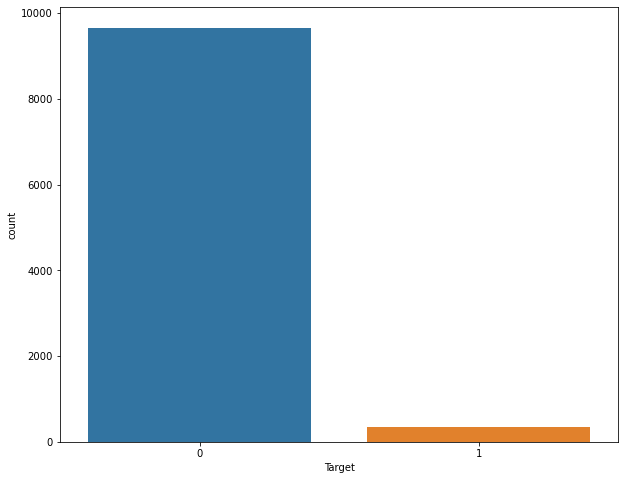

In [13]:
# now i make the visulization to make more sense about the data 
plt.figure(figsize=(10,8))
sns.countplot(data=df,x='Target')

as i saw in countplot the system are not failure complete most of the time 
let's see the error of failure in machine maintenance accoure 

<Axes: xlabel='Failure Type', ylabel='count'>

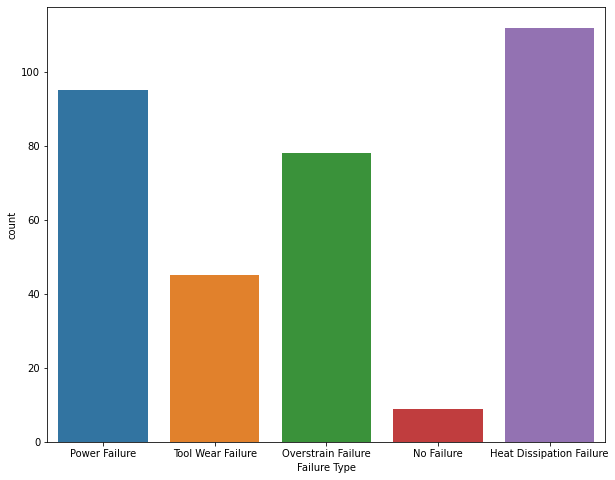

In [14]:
plt.figure(figsize=(10,8))
sns.countplot(data=df[df['Target']==1],x='Failure Type')

 by using the target variabel, we obtain the number of errors according to the error type the Heat Dissiption,Power Failure are accoured most of time in the failure of the system 

 Now i check the distribution of other variable acording to the target variable using pairplot

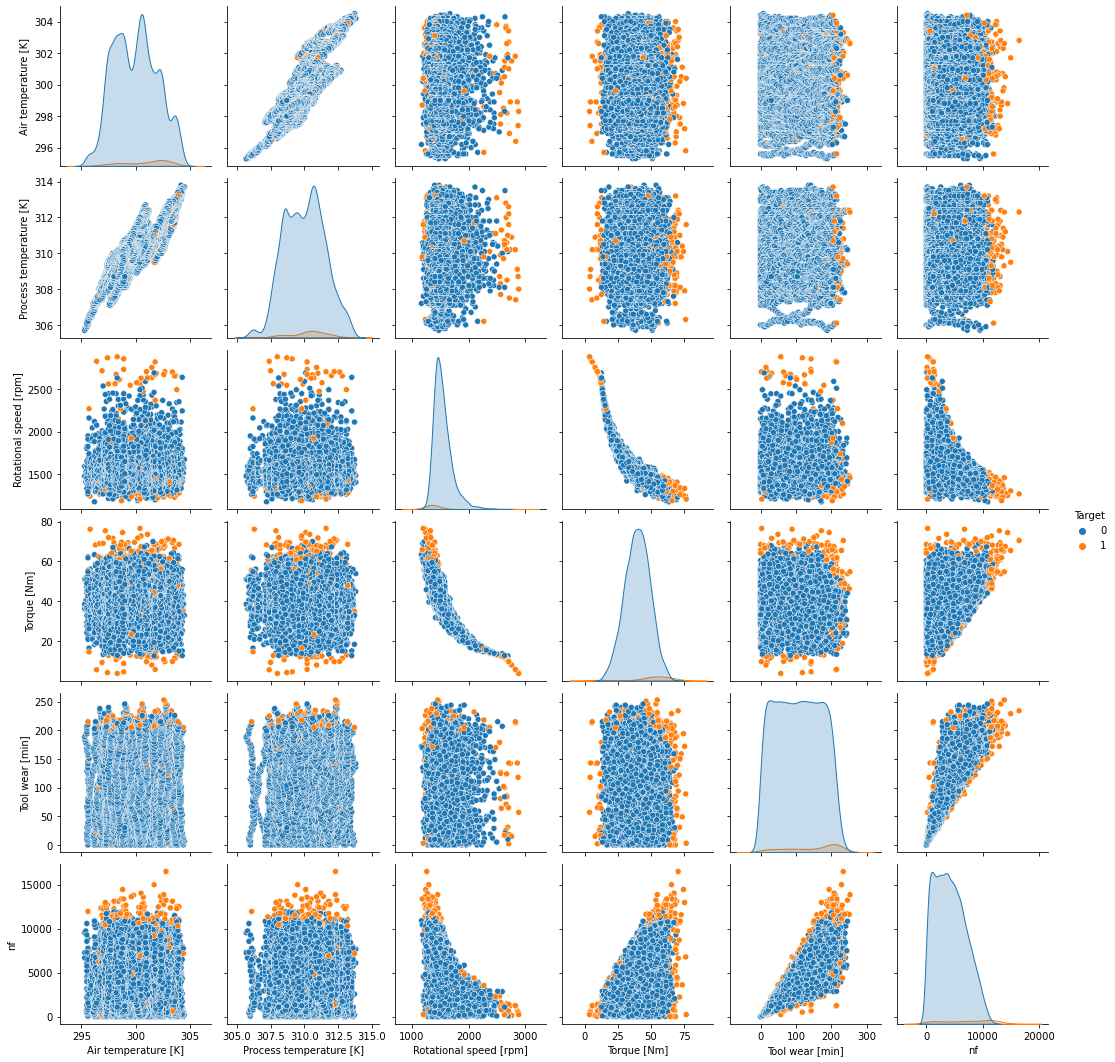

In [15]:
sns.pairplot(df,hue='Target')

After seening the distribution of variable according to the target variable,  now i use the heat map to seethe level of relationship of the variable with each other 

<Axes: >

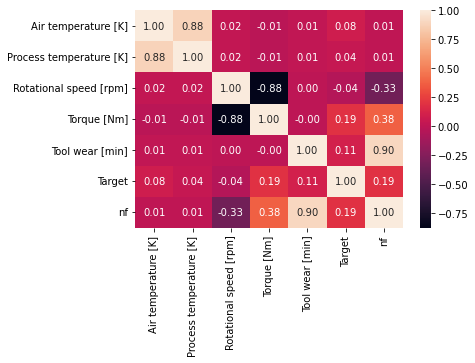

In [16]:
sns.heatmap(df.corr(),annot=True ,fmt='.2f')

* After seening the correlation levels and direction of the variable with each other 
* let's observe the variablity other numerical variable according to the target variable with the boxplot:
  

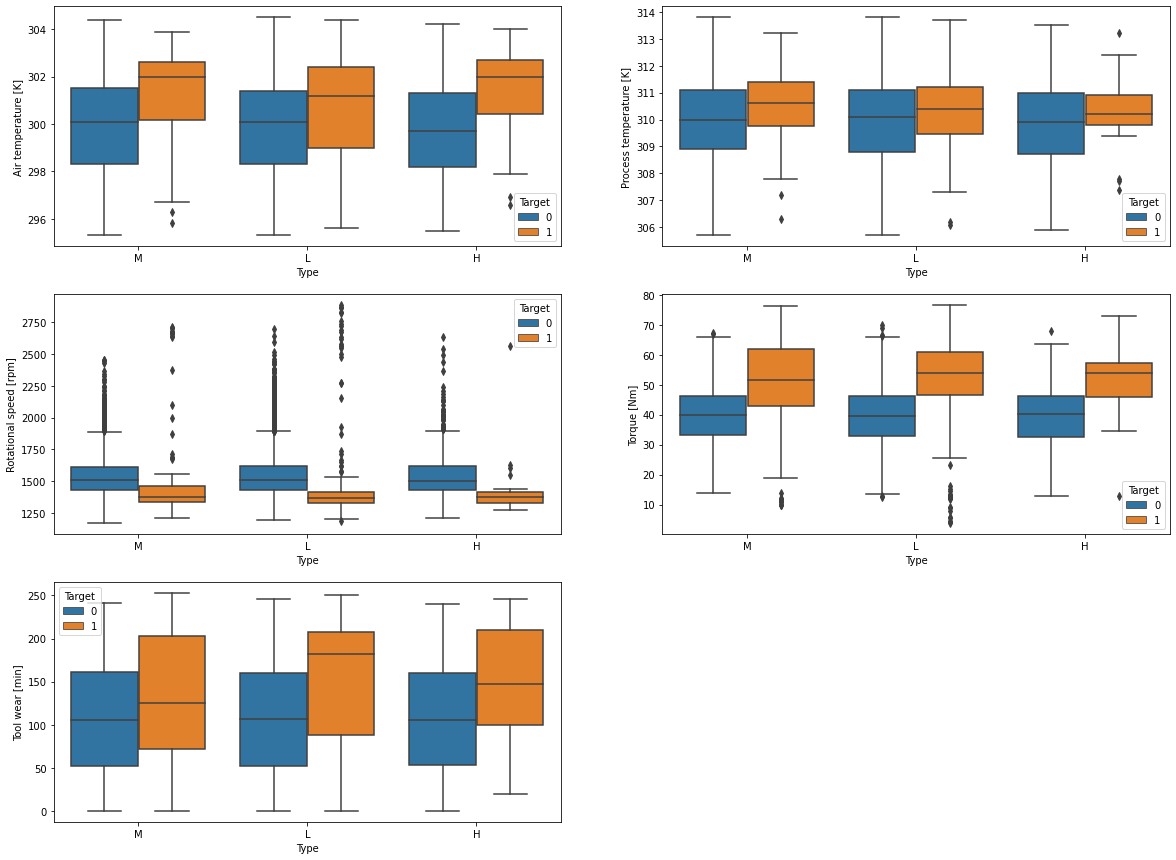

In [22]:
plt.figure(figsize=(20,15))
m =1
for i in['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']:
    plt.subplot(3,2,m)
    sns.boxplot(data=df,y=i,x='Type',hue='Target')
    m+=1

After visulization the state of the target variable according to the numerical variable with the various graphics, i perform the visulization process on the common axis according to `Torque, Rotational Power and Tool wear` variables. For this 3D graphics 

In [23]:
import plotly.express as px
fig = px.scatter_3d(df,x='Tool wear [min]',y='Torque [Nm]',z='Rotational speed [rpm]',color='Target')
fig.show()

# Data prepocessing for the models
i performed the visulization according to the variable in our dataset. After completing our EDA process i perform the data preprocessing such as encoding for our dataset for the machine learning model 

In [24]:
df['Type'] = df['Type'].replace('L',0)
df['Type'] = df['Type'].replace('M',1)
df['Type'] = df['Type'].replace('H',2)


i changed the text column with  numerical variable. 

# Spliting the dataset into test train for ML algorithm

In [45]:

df_target = df.Target.copy()
df_failure_type = df["Failure Type"].copy()

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Failure Type','Target'],axis=1),
                                                    df['Target'], test_size=0.3, random_state=42)


In [28]:
! pip install lightgbm


ERROR: Could not find a version that satisfies the requirement lightgbm (from versions: none)
ERROR: No matching distribution found for lightgbm


In [46]:
# create the class taht display the accuracy score of ML
import time 

from sklearn.metrics import accuracy_score,classification_report
classifier = []
imported_as = []

# LGBM
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
classifier.append('LightGBM')
imported_as.append('lgbm')

# MultiLayerPerception
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
classifier.append('Multi Layer Pereption')
imported_as.append('mlp')

# Bagging
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
classifier.append('Bagging')
imported_as.append('bc')

# GBC
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
classifier.append('Gradient Boosting')
imported_as.append('gbc')

# ADA
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
classifier.append('Ada Boost')
imported_as.append('ada')

#XGB

import xgboost as xgb
from xgboost import XGBClassifier
xgb = XGBClassifier()
classifier.append('XF Boost')
imported_as.append('xgb')

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier.append('Logistic Regression')
imported_as.append('lr')


# RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('lr')

# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
classifier.append('K Nearest Neighbor')
imported_as.append('Knn')

# svm
from sklearn.svm import SVC
svc = SVC()
classifier.append('Support vector machine')
imported_as.append('svc')

# Grid 
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1,1,0,10,100],'gamma':[1,0.1,0.01,0.001],'kernel':['rbf']}
classifier.append('SVM tunning grid')
imported_as.append('grid')

# Stacking 

from sklearn.ensemble import StackingClassifier
estimators = [('rf',RandomForestClassifier(n_estimators=10,random_state=42)),('svc',SVC(random_state=42))]
stc = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())

classifier.append('Stacked(RFR & SM)')
imported_as.append('stc')
classifier = pd.DataFrame({'Classifier':classifier,'Imported as ':imported_as})
print('All models imported')

All models imported


After the library imported for machine learning algo-rithms i created the class and list the accuracy score of each machine learning algorithm. i would also like to that this technique, in which i run the model i use the compact way by creating the single class is a technique that can make the work of the data scientist much easier and i especially recomended it to be include in the templates used in the project flow

In [47]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            model_acc.append(accuracy_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,'Accuracy':model_acc,'Runtime (s)':model_time})
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['Accuracy','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['Accuracy']=models['Accuracy'].round(5)*100
        self.models_output_cleaned=models
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [48]:
display(classifier)

,Classifier,Imported as
0,LightGBM,lgbm
1,Multi Layer Pereption,mlp
2,Bagging,bc
3,Gradient Boosting,gbc
4,Ada Boost,ada
5,XF Boost,xgb
6,Logistic Regression,lr
7,Random Forest,lr
8,K Nearest Neighbor,Knn
9,Support vector machine,svc


We fit the machine learning algorithms to be used and show the accuracy scores in a list:

In [49]:
models_to_test = [bc,gbc,ada,rfc,mlp,lr,knn,stc]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     7000 non-null   int64  
 1   Air temperature [K]      7000 non-null   float64
 2   Process temperature [K]  7000 non-null   float64
 3   Rotational speed [rpm]   7000 non-null   int64  
 4   Torque [Nm]              7000 non-null   float64
 5   Tool wear [min]          7000 non-null   int64  
 6   nf                       7000 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 437.5 KB


In [51]:
classification = Modelling(X_train,y_train,X_test,y_test,models_to_test)
classification.fit()


BaggingClassifier() has been fit
GradientBoostingClassifier() has been fit
AdaBoostClassifier() has been fit
RandomForestClassifier() has been fit
MLPClassifier() has been fit
LogisticRegression() has been fit
KNeighborsClassifier(n_neighbors=1) has been fit
StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc', SVC(random_state=42))],
                   final_estimator=LogisticRegression()) has been fit


In [52]:
classification.results()

,Models,Accuracy,Runtime (s)
0,BaggingClassifier,99.133,12.791998
1,RandomForestClassifier,98.800,29.003627
2,GradientBoostingClassifier,98.800,40.281177
3,StackingClassifier,98.633,58.401935
4,AdaBoostClassifier,97.667,11.432831
5,LogisticRegression,97.400,3.072001
6,MLPClassifier,96.933,12.712002
7,KNeighborsClassifier,96.067,5.747017


i can see the hit scores of various machine learning algorithms in the list. Well, we have come to the end of our study. In this section of our study, we focused on solving the problem in a very simple way by writing a class that contains many different algorithm